<h1>Define headers</h1>

In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode

# import some common libraries
import numpy as np
import cv2
import random
import os
import json
import time
import statistics 
import math  

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error

from PIL import Image

import torch
torch.cuda.set_device(1)

<h1> Define Dataset</h1>

In [2]:
def get_ball_dicts():
    txt_file = os.path.join("/home/daniela/workspace/ball_detection/Datasets/train/", "open_images.txt")
    f = open(txt_file, "r")
    c=0
    dataset_dicts = []
    
    for line in f:
        record = {}
        objs = []
        c+=1

        filename=line[49+4:69+4]
        width, height = Image.open(os.path.join("/home/daniela/workspace/ball_detection/Datasets/train/Ball/", filename)).size

        record["file_name"] = os.path.join("/home/daniela/workspace/ball_detection/Datasets/train/Ball/", filename)
        record["image_id"] = c
        record["height"] = height
        record["width"] = width

        label_txt="/home/daniela/workspace/ball_detection/Datasets/train/Label/"+filename[:16]+".txt"
        f_label = open(label_txt, "r")

        for line_label in f_label:
            px=[]
            py=[]
            x = line_label.split()
            px.append(float(x[1]))
            px.append(float(x[3]))
            py.append(float(x[2]))
            py.append(float(x[4]))
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)    
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

def get_ball_dicts_grayscale():
    txt_file = os.path.join("/home/daniela/workspace/ball_detection/Datasets/train/", "open_images_grayscale.txt")
    f = open(txt_file, "r")
    c=0
    dataset_dicts = []
    
    for line in f:
        record = {}
        objs = []
        c+=1

        filename=line[49+4+1:69+4+1]
        width, height = Image.open(os.path.join("/home/daniela/workspace/ball_detection/Datasets/train/Grayscale/", filename)).size

        record["file_name"] = os.path.join("/home/daniela/workspace/ball_detection/Datasets/train/Grayscale/", filename)
        record["image_id"] = c
        record["height"] = height
        record["width"] = width

        label_txt="/home/daniela/workspace/ball_detection/Datasets/train/Label/"+filename[:16]+".txt"
        f_label = open(label_txt, "r")

        for line_label in f_label:
            px=[]
            py=[]
            x = line_label.split()
            px.append(float(x[1]))
            px.append(float(x[3]))
            py.append(float(x[2]))
            py.append(float(x[4]))
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)    
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


from detectron2.data import DatasetCatalog, MetadataCatalog
DatasetCatalog.register("Ball_train", lambda:get_ball_dicts())
MetadataCatalog.get("Ball_train").set(thing_classes=["Ball"])
ball_metadata = MetadataCatalog.get("Ball_train")


DatasetCatalog.register("Ball_train_bw", lambda:get_ball_dicts_grayscale())
MetadataCatalog.get("Ball_train_bw").set(thing_classes=["Ball"])
ball_metadata = MetadataCatalog.get("Ball_train_bw")

<h1>Confirm if datasets works</h1>

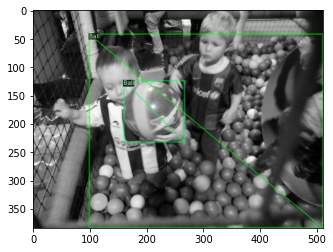

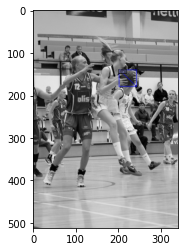

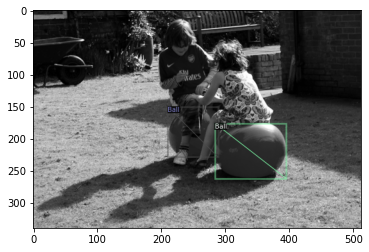

In [3]:
import random 
import matplotlib.pyplot as plt
dataset_dicts = get_ball_dicts_grayscale()
ball_metadata = MetadataCatalog.get("Ball_train_bw")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=ball_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image()[:, :, ::-1])
    


In [4]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"))
cfg.DATASETS.TRAIN = ("Ball_train_bw",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 7000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

WARNING [09/29 10:48:28 d2.modeling.backbone.resnet]: ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.
[09/29 10:48:29 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (

In [5]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("ball_train", )
predictor = DefaultPredictor(cfg)

WARNING [09/29 10:48:31 d2.modeling.backbone.resnet]: ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.


In [6]:
cameraMatrix_IR=np.array([[705.1735, 0.000000, 172.6855],
                          [0.000000, 710.7784, 148.5702],
                          [0.000000, 0.000000, 1.000000]])

cameraMatrix_rgb_pointgrey=np.array([[1152.437560398629, 0, 478.3335229505631], 
                                    [0, 1155.693500473246, 351.508630859905], 
                                    [0, 0, 1]])
cameraMatrix_mono=np.array([[2363.738690444174,0,1072.79004424623],
[0,2370.592662770868, 788.4498446284557],
[0,0,1]])

cameraMatrix_rgb_kinect=np.array([[528.4117387071603, 0, 302.5975195203697], 
                                  [0, 529.2065975242205, 267.595550019321], 
                                  [0, 0, 1]])



cameraMatrix_depth=([[591.7721324849275, 0, 317.7580947095767], 
                     [0, 592.7705069723955, 246.0294085129425], 
                     [0, 0, 1]])

fx_mono=cameraMatrix_mono[0][0]
fy_mono=cameraMatrix_mono[1][1]
cx_mono=cameraMatrix_mono[0][2]
cy_mono=cameraMatrix_mono[1][2]

fx_ir=cameraMatrix_IR[0][0]
fy_ir=cameraMatrix_IR[1][1]
cx_ir=cameraMatrix_IR[0][2]
cy_ir=cameraMatrix_IR[1][2]

fx_rgb=cameraMatrix_rgb_kinect[0][0]
fy_rgb=cameraMatrix_rgb_kinect[1][1]
cx_rgb=cameraMatrix_rgb_kinect[0][2]
cy_rgb=cameraMatrix_rgb_kinect[1][2]

fx_depth=cameraMatrix_depth[0][0]
fy_depth=cameraMatrix_depth[1][1]
cx_depth=cameraMatrix_depth[0][2]
cy_depth=cameraMatrix_depth[1][2]

print(fx_rgb,fy_rgb,cx_rgb,cy_rgb)

d_real=0.63 *1000#mm


528.4117387071603 529.2065975242205 302.5975195203697 267.595550019321


<h1> Plot 3D real points </h1>

In [7]:
#read txt files with image path
# /home/daniela/workspace/ball_detection/Datasets/train/4_cam_new
txt_file_rgb =os.path.join("/home/daniela/workspace/ball_detection/Datasets/train/4cams_sep1/", "rgb.txt")
f_rgb = open(txt_file_rgb, "r")

txt_file_ir = os.path.join("/home/daniela/workspace/ball_detection/Datasets/train/4cams_sep1/", "ir.txt")
f_ir = open(txt_file_ir, "r")

txt_file_mono =os.path.join("/home/daniela/workspace/ball_detection/Datasets/train/4cams_sep1/", "mono.txt")
f_mono = open(txt_file_mono, "r")

txt_file_depth =os.path.join("/home/daniela/workspace/ball_detection/Datasets/train/4cams_sep1/", "depth.txt")
f_depth = open(txt_file_depth, "r")

#initiate vectors
xpi=[]
ypi=[]
xpr=[]
ypr=[]
xpm=[]
ypm=[]
xpd=[]
ypd=[]
dm=[]
di=[]
dr=[]
dd=[]
c=0
c_for=0

#for each figure in the path
for line_rgb in f_rgb: 
    c_for+=1
    # read images and calculate detected bounding box for each camera
    im_rgb = cv2.imread(line_rgb[:len(line_rgb)-1])
    outputs_rgb = predictor(im_rgb)
    results_rgb=outputs_rgb["instances"].to("cpu")
    
    line_ir=f_ir.readline()
    line_mono=f_mono.readline()
    line_depth=f_depth.readline()
    if(line_ir=="" or line_mono=="" or line_depth==""):
        break
    im_ir = cv2.imread(line_ir[:len(line_ir)-1])
    outputs_ir = predictor(im_ir)
    results_ir=outputs_ir["instances"].to("cpu")
    
    im_mono = cv2.imread(line_mono[:len(line_mono)-1])
    outputs_mono = predictor(im_mono)
    results_mono=outputs_mono["instances"].to("cpu")
    
    im_depth = cv2.imread(line_depth[:len(line_depth)-1])
    outputs_depth = predictor(im_depth)
    results_depth=outputs_depth["instances"].to("cpu")

    # CALCULATE CENTERS - remove images without detection in both timestamp
    if(len(results_rgb)!=0 and len(results_ir)!=0 and len(results_mono)!=0 and len(results_depth)!=0):
        coordinates_ir=results_ir.pred_boxes.tensor[0].numpy()
        coordinates_rgb=results_rgb.pred_boxes.tensor[0].numpy()
        coordinates_mono=results_mono.pred_boxes.tensor[0].numpy()
        coordinates_depth=results_depth.pred_boxes.tensor[0].numpy()


        cond1=(abs((coordinates_rgb[2]-coordinates_rgb[0])-(coordinates_rgb[3]-coordinates_rgb[1]))>=0.07*max((coordinates_rgb[2]-coordinates_rgb[0]),(coordinates_rgb[3]-coordinates_rgb[1])))
        cond2=(abs((coordinates_ir[2]-coordinates_ir[0])-(coordinates_ir[3]-coordinates_ir[1]))>=0.07*max((coordinates_ir[2]-coordinates_ir[0]),(coordinates_ir[3]-coordinates_ir[1])))
        cond3=(abs((coordinates_mono[2]-coordinates_mono[0])-(coordinates_mono[3]-coordinates_mono[1]))>=0.07*max((coordinates_mono[2]-coordinates_mono[0]),(coordinates_mono[3]-coordinates_mono[1])))
        cond4=(abs((coordinates_depth[2]-coordinates_depth[0])-(coordinates_depth[3]-coordinates_depth[1]))>=0.07*max((coordinates_depth[2]-coordinates_depth[0]),(coordinates_depth[3]-coordinates_depth[1])))

        
        if(cond1==False and cond2==False and cond3==False and cond4==False):
            #VISUAL
            xc_rgb=(coordinates_rgb[2]-coordinates_rgb[0])/2+coordinates_rgb[0]
            yc_rgb=(coordinates_rgb[3]-coordinates_rgb[1])/2+coordinates_rgb[1]
            xc_rgb=float("%0.2f"%xc_rgb)
            yc_rgb=float("%0.2f"%yc_rgb)

            dx_rgb=float("%0.2f"%(float("%0.2f"%coordinates_rgb[2])-float("%0.2f"%coordinates_rgb[0])))
            dy_rgb=float("%0.2f"%(float("%0.2f"%coordinates_rgb[3])-float("%0.2f"%coordinates_rgb[1])))
            d_pix_rgb=(dx_rgb+dy_rgb)/2

            #IR
            xc_ir=(coordinates_ir[2]-coordinates_ir[0])/2+coordinates_ir[0]
            yc_ir=(coordinates_ir[3]-coordinates_ir[1])/2+coordinates_ir[1]
            xc_ir=float("%0.2f"%xc_ir)
            yc_ir=float("%0.2f"%yc_ir)

            dx_ir=float("%0.2f"%(float("%0.2f"%coordinates_ir[2])-float("%0.2f"%coordinates_ir[0])))
            dy_ir=float("%0.2f"%(float("%0.2f"%coordinates_ir[3])-float("%0.2f"%coordinates_ir[1])))
            d_pix_ir=(dx_ir+dy_ir)/2

            #mono
            xc_mono=(coordinates_mono[2]-coordinates_mono[0])/2+coordinates_mono[0]
            yc_mono=(coordinates_mono[3]-coordinates_mono[1])/2+coordinates_mono[1]
            xc_mono=float("%0.2f"%xc_mono)
            yc_mono=float("%0.2f"%yc_mono)

            dx_mono=float("%0.2f"%(float("%0.2f"%coordinates_mono[2])-float("%0.2f"%coordinates_mono[0])))
            dy_mono=float("%0.2f"%(float("%0.2f"%coordinates_mono[3])-float("%0.2f"%coordinates_mono[1])))
            d_pix_mono=(dx_mono+dy_mono)/2

            #depth
            xc_depth=(coordinates_depth[2]-coordinates_depth[0])/2+coordinates_depth[0]
            yc_depth=(coordinates_depth[3]-coordinates_depth[1])/2+coordinates_depth[1]
            xc_depth=float("%0.2f"%xc_depth)
            yc_depth=float("%0.2f"%yc_depth)

            dx_depth=float("%0.2f"%(float("%0.2f"%coordinates_depth[2])-float("%0.2f"%coordinates_depth[0])))
            dy_depth=float("%0.2f"%(float("%0.2f"%coordinates_depth[3])-float("%0.2f"%coordinates_depth[1])))
            d_pix_depth=(dx_depth+dy_depth)/2

            #append points
            xpr.append(xc_rgb)
            ypr.append(yc_rgb)
            xpi.append(xc_ir)
            ypi.append(yc_ir)
            xpm.append(xc_mono)
            ypm.append(yc_mono)
            xpd.append(xc_depth)
            ypd.append(yc_depth)
            dm.append(d_pix_mono)
            dr.append(d_pix_rgb)
            di.append(d_pix_ir)
            dd.append(d_pix_depth)
            
            c+=1
            
f_ir.close()        
f_rgb.close()
print(c,c_for)

/home/daniela/miniconda3/envs/torch/lib/python3.7/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:111: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  filter_inds = filter_mask.nonzero()


82 2220


In [8]:
def find_optimal_fraction(fx,fy,d_pix):
    d_real=630
    dst=1000
    frac=1
    while (abs(dst)>10):
        Z=((fx+fy)/2)*(d_real*frac/d_pix)
        frac=Z/(Z+(d_real/2))
        Z_new=((fx+fy)/2)*(d_real*frac/d_pix)
        dst=Z-Z_new
#     print(frac)
    return Z_new

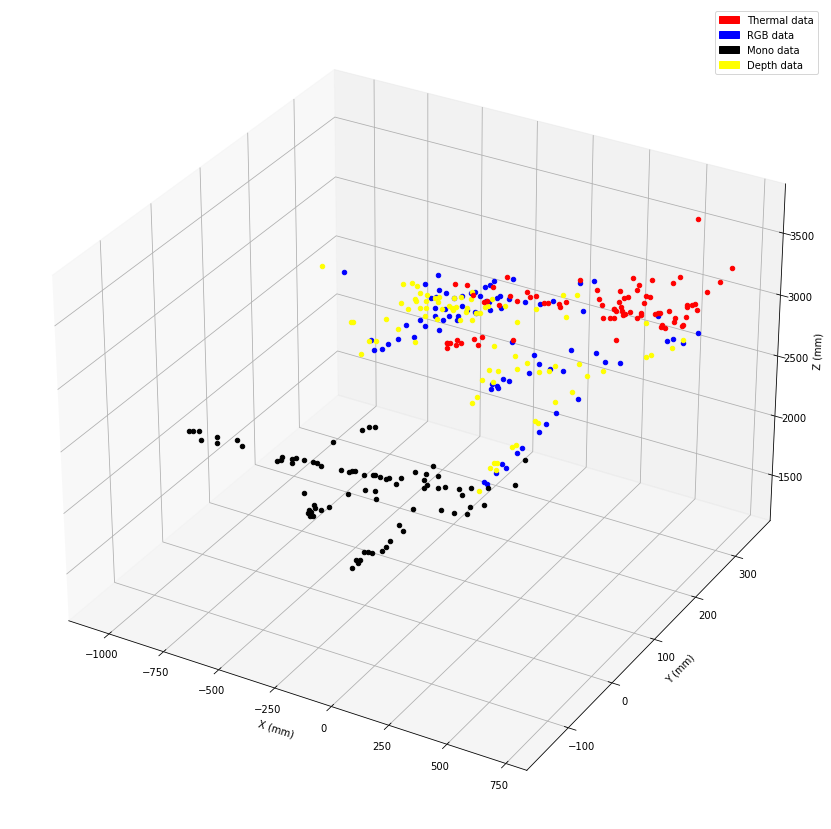

In [9]:
Xt=[]
Yt=[]
Zt=[]
Xr=[]
Yr=[]
Zr=[]
Xm=[]
Ym=[]
Zm=[]
Xd=[]
Yd=[]
Zd=[]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d' )
black_patch = mpatches.Patch(color='black', label='Mono data')
blue_patch = mpatches.Patch(color='blue', label='RGB data')
red_patch = mpatches.Patch(color='red', label='Thermal data')
yellow_patch = mpatches.Patch(color='yellow', label='Depth data')
plt.legend(handles=[red_patch,blue_patch,black_patch, yellow_patch])

ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')


for n in range(0,len(xpi)):
    Z_rgb=find_optimal_fraction(fx_rgb,fy_rgb,dr[n])#((fx_rgb+fy_rgb)/2)*(d_real/d_pix_rgb)
    X_rgb=(Z_rgb*(xpr[n]-cx_rgb))/fx_rgb
    Y_rgb=(Z_rgb*(ypr[n]-cy_rgb))/fy_rgb
    
    Z_ir=find_optimal_fraction(fx_ir,fy_ir,di[n])
    X_ir=(Z_ir*(xpi[n]-cx_ir))/fx_ir
    Y_ir=(Z_ir*(ypi[n]-cy_ir))/fy_ir
    
    Z_mono=find_optimal_fraction(fx_mono,fy_mono,dm[n])
    X_mono=(Z_mono*(xpm[n]-cx_mono))/fx_mono
    Y_mono=(Z_mono*(ypm[n]-cy_mono))/fy_mono
    
    Z_depth=find_optimal_fraction(fx_depth,fy_depth,dd[n])
    X_depth=(Z_depth*(xpd[n]-cx_depth))/fx_depth
    Y_depth=(Z_depth*(ypd[n]-cy_depth))/fy_depth
    
    if (Z_ir<30000):
        Xr.append(X_rgb)
        Yr.append(Y_rgb)
        Zr.append(Z_rgb)
        
        Xt.append(X_ir)
        Yt.append(Y_ir)
        Zt.append(Z_ir) 
        
        Xm.append(X_mono)
        Ym.append(Y_mono)
        Zm.append(Z_mono)
        
        Xd.append(X_depth)
        Yd.append(Y_depth)
        Zd.append(Z_depth) 


        ax.scatter(X_rgb, Y_rgb, Z_rgb, c='b') #draw in plot
        ax.scatter(X_ir, Y_ir, Z_ir, c='r')
        ax.scatter(X_mono, Y_mono, Z_mono, c='black')
        ax.scatter(X_depth, Y_depth, Z_depth, c='yellow')
    

<h1>Plot pixel points vs real distance to ball</h1>

(480, 640, 3)

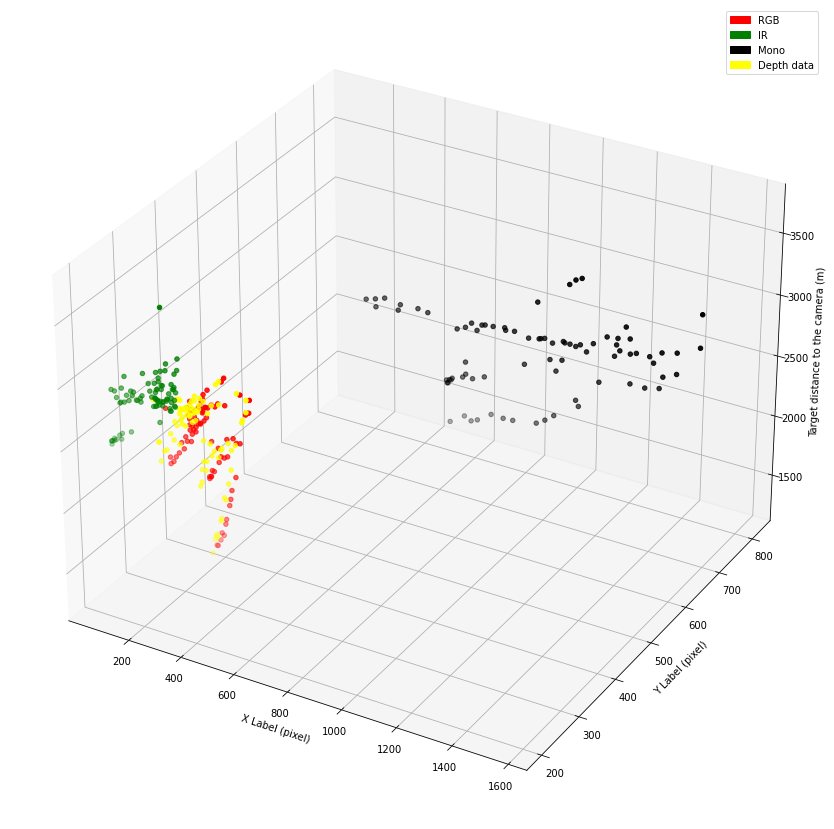

In [10]:
fig3 = plt.figure(figsize=(15,15))
ax3 = fig3.add_subplot(111, projection='3d' )
blue_patch = mpatches.Patch(color='green', label='IR')
red_patch = mpatches.Patch(color='red', label='RGB')
black_patch = mpatches.Patch(color='black', label='Mono')
yellow_patch = mpatches.Patch(color='yellow', label='Depth data')

plt.legend(handles=[red_patch,blue_patch,black_patch,yellow_patch])
ax3.set_xlabel('X Label (pixel)')
ax3.set_ylabel('Y Label (pixel)')
ax3.set_zlabel('Target distance to the camera (m)')


ax3.scatter(xpr,ypr,Zr, c='r')
ax3.scatter(xpi,ypi,Zt, c='g')
ax3.scatter(xpm,ypm,Zm, c='k')
ax3.scatter(xpd,ypd,Zd, c='yellow')
# print(xpi)
# print(xpr)
im_rgb.shape

<h1>Plot Ball Center in Pixels</h1>

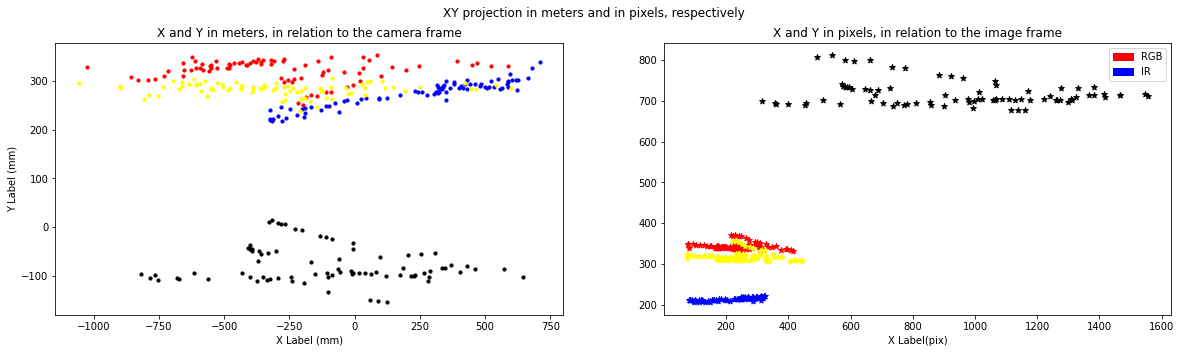

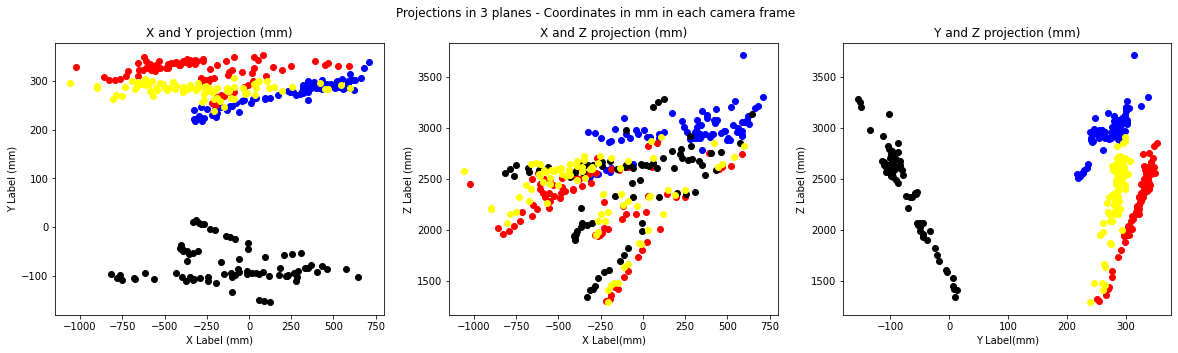

In [11]:
fig0, axs_0 = plt.subplots(1,2,figsize=(20,5))
blue_patch = mpatches.Patch(color='blue', label='IR')
red_patch = mpatches.Patch(color='red', label='RGB')
plt.legend(handles=[red_patch,blue_patch])

fig0.suptitle("XY projection in meters and in pixels, respectively ")

axs_0[0].scatter(Xr,Yr,c='r',s=10)
axs_0[0].scatter(Xt,Yt,c='b',s=10)
axs_0[0].scatter(Xm,Ym,c='k',s=10)
axs_0[0].scatter(Xd,Yd,c='yellow',s=10)
axs_0[0].set_xlabel('X Label (mm)')
axs_0[0].set_ylabel('Y Label (mm)')
axs_0[0].set_title('X and Y in meters, in relation to the camera frame')

axs_0[1].scatter(xpr,ypr,c='r',marker="*")
axs_0[1].scatter(xpi,ypi,c='b',marker="*")
axs_0[1].scatter(xpm,ypm,c='k',marker="*")
axs_0[1].scatter(xpd,ypd,c='yellow',marker="*")
axs_0[1].set_xlabel('X Label(pix)')
axs_0[1].set_title('X and Y in pixels, in relation to the image frame')

fig_proj, axs_proj = plt.subplots(1,3,figsize=(20,5))

fig_proj.suptitle("Projections in 3 planes - Coordinates in mm in each camera frame")

axs_proj[0].scatter(Xt,Yt, c='b')
axs_proj[0].scatter(Xr,Yr, c='r')
axs_proj[0].scatter(Xm,Ym, c='k')
axs_proj[0].scatter(Xd,Yd, c='yellow')
axs_proj[0].set_xlabel('X Label (mm)')
axs_proj[0].set_ylabel('Y Label (mm)')
axs_proj[0].set_title('X and Y projection (mm)')

axs_proj[1].scatter(Xt, Zt,c='b')
axs_proj[1].scatter(Xr, Zr,c='r')
axs_proj[1].scatter(Xm, Zm,c='k')
axs_proj[1].scatter(Xd, Zd,c='yellow')
axs_proj[1].set_xlabel('X Label(mm)')
axs_proj[1].set_ylabel('Z Label (mm)')
axs_proj[1].set_title('X and Z projection (mm)')

axs_proj[2].scatter(Yt,Zt, c='b')
axs_proj[2].scatter(Yr,Zr, c='r')
axs_proj[2].scatter(Ym,Zm, c='k')
axs_proj[2].scatter(Yd,Zd, c='yellow')
axs_proj[2].set_xlabel('Y Label(mm)')
axs_proj[2].set_ylabel('Z Label (mm)')
axs_proj[2].set_title('Y and Z projection (mm)')

plt.show()

<h1>Calculate transformations (from RGB to Thermal) </h1> 

In [62]:
objectPoints1=np.array([Xr,Yr,Zr]).T #RGB
objectPoints2=np.array([Xt,Yt,Zt]).T #Termica
objectPoints3=np.array([Xm,Ym,Zm]).T #Mono
objectPoints4=np.array([Xd,Yd,Zd]).T #Depth
# print(objectPoints1.T,objectPoints1.T[:,:40])

# objectPoints=[objectPoints4[chauvenet(rmse_vec[i,:]),:],objectPoints1[chauvenet(rmse_vec[i,:]),:],objectPoints2[chauvenet(rmse_vec[i,:]),:],objectPoints3[chauvenet(rmse_vec[i,:]),:]]
objectPoints=[objectPoints4,objectPoints1,objectPoints2,objectPoints3]
print (objectPoints[0].shape)

(82, 3)


In [63]:
def transformation(points, rotation_matrix):
    new_points= np.empty([points.shape[0], 3])
    for n in range(0,points.shape[0]):
        point=np.array([points[n,0],points[n,1],points[n,2],1])
#         new_points[n,0] = rotation_matrix[0,0] * points[n, 0] + rotation_matrix[0,1] * points[n, 1] + rotation_matrix[0,2] * points[n, 2] + rotation_matrix[0,3]
#         new_points[n,1] = rotation_matrix[1,0] * points[n, 0] + rotation_matrix[1,1] * points[n, 1] + rotation_matrix[1,2] * points[n, 2] + rotation_matrix[1,3]
#         new_points[n,2] = rotation_matrix[2,0] * points[n, 0] + rotation_matrix[2,1] * points[n, 1] + rotation_matrix[2,2] * points[n, 2] + rotation_matrix[2,3]
        new_points[n,:]=rotation_matrix[:3,:]@point
    return new_points

In [64]:
def best_fit_transform(A, B):
    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
       Vt[m-1,:] *= -1
       R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t


def icp(A, B, init_pose=None, max_iterations=1000, tolerance=0.0001):
    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1,A.shape[0]))
    dst = np.ones((m+1,B.shape[0]))
    src[:m,:] = np.copy(A.T)
    dst[:m,:] = np.copy(B.T)


    T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,:].T)
    transformed_points=np.dot(T,src)

    return T, transformed_points[:m,:].T

from scipy import special
    
def chauvenet(array):
    mean = array.mean()           # Mean of incoming array
    stdv = array.std()            # Standard deviation
    N = len(array)                # Lenght of incoming array
    criterion = 1.0/(2*N)         # Chauvenet's criterion
    d = abs(array-mean)/stdv      # Distance of a value to mean in stdv's
    prob = special.erfc(d)        # Area normal dist.    
    new_array=array[prob < criterion]
    idx=np.where(prob < criterion)[0]
    new_mean = new_array.mean()           # Mean of incoming array
    new_stdv = new_array.std()            # Standard deviation
    N_new = len(new_array)                # Lenght of incoming array
    new_criterion = 1.0/(2*N_new)         # Chauvenet's criterion
    new_d = abs(new_array-new_mean)/new_stdv      # Distance of a value to mean in stdv's
    new_prob = special.erfc(new_d)        # Area normal dist.  
    idx_again=np.where(new_prob < new_criterion)[0]
#     print(idx,idx_again)
    bool_array=np.ones(array.shape, dtype=bool)
    bool_array2=np.ones(array.shape, dtype=bool)
    bool_array[idx]=False
#     print(bool_array)
    c=0
    for n in range(N):
        if bool_array[n]==False:
            c+=1
        elif n in idx_again:
            bool_array2[n+c]=False
#     print(bool_array2)
    bool_array[bool_array2==False]=False
        
        
    return bool_array      # Use boolean array outside this function


In [65]:
def chauvenet2(array):
    mean = array.mean()           # Mean of incoming array
    stdv = array.std()            # Standard deviation
    N = len(array)                # Lenght of incoming array
    criterion = 1-1.0/(2*N)         # Chauvenet's criterion
    d = abs(array-mean)/stdv      # Distance of a value to mean in stdv's
    prob = special.erfc(d)        # Area normal dist.    
    idx=np.concatenate((np.where(prob > criterion)[0], np.where(prob < 1-criterion)[0]) ,axis=0)
    bool_array=np.ones(array.shape, dtype=bool)
    new_array=np.delete(array, idx)
    count=0
    for i in range(0,5):
        new_mean = new_array.mean()           # Mean of incoming array
        new_stdv = new_array.std()            # Standard deviation
        N_new = len(new_array)                # Lenght of incoming array
        new_criterion =1- 1.0/(2*N_new)         # Chauvenet's criterion
        new_d = abs(new_array-new_mean)/new_stdv      # Distance of a value to mean in stdv's
        new_prob = special.erfc(new_d)        # Area normal dist.  
        idx_again=np.concatenate((np.where(new_prob > new_criterion)[0], np.where(new_prob < 1-new_criterion)[0]) ,axis=0)
        if np.array_equal(idx_again,idx):
            break
        bool_array2=np.ones(array.shape, dtype=bool)
        bool_array[idx]=False
        c=0
        for n in range(N):
            if bool_array[n]==False:
                c+=1
            elif n in idx_again:
                bool_array2[n+c]=False
        bool_array[bool_array2==False]=False
        idx=idx_again
        prob=new_prob
        criterion=new_criterion
        new_array=array[bool_array==True]
        count+=1

    return bool_array      # Use boolean array outside this function
# print(rmse_vec_pairwise1[2,:])
# print(chauvenet2(rmse_vec_pairwise1[2,:]))
# rmse_vec_pairwise1[2,(chauvenet2(rmse_vec_pairwise1[2,:]))]

In [66]:
T_12,transformed_points_12=icp(objectPoints[0],objectPoints[1])
rmse_12=mean_squared_error(transformed_points_12,objectPoints[1],squared=False)

T_21, transformed_points_21=icp(objectPoints[1],objectPoints[0])
rmse_21=mean_squared_error(transformed_points_21,objectPoints[0],squared=False)

T_13,transformed_points_13 =icp(objectPoints[0],objectPoints[2])
rmse_13=mean_squared_error(transformed_points_13,objectPoints[2],squared=False)

T_31,transformed_points_31 =icp(objectPoints[2],objectPoints[0])
rmse_31=mean_squared_error(transformed_points_31,objectPoints[0],squared=False)

T_23, transformed_points_23=icp(objectPoints[1],objectPoints[2])
rmse_23=mean_squared_error(transformed_points_23,objectPoints[2],squared=False)

T_32,transformed_points_32 =icp(objectPoints[2],objectPoints[1])
rmse_32=mean_squared_error(transformed_points_32,objectPoints[1],squared=False)


T_14,transformed_points_14 =icp(objectPoints[0],objectPoints[3])
rmse_14=mean_squared_error(transformed_points_14,objectPoints[3],squared=False)

T_41, transformed_points_41=icp(objectPoints[3],objectPoints[0])
rmse_41=mean_squared_error(transformed_points_41,objectPoints[0],squared=False)

T_43,transformed_points_43=icp(objectPoints[3],objectPoints[2])
rmse_43=mean_squared_error(transformed_points_43,objectPoints[2],squared=False)

T_34,transformed_points_34 =icp(objectPoints[2],objectPoints[3])
rmse_34=mean_squared_error(transformed_points_34,objectPoints[3],squared=False)

T_24, transformed_points_24=icp(objectPoints[1],objectPoints[3])
rmse_24=mean_squared_error(transformed_points_24,objectPoints[3],squared=False)

T_42, transformed_points_42=icp(objectPoints[3],objectPoints[1])
rmse_42=mean_squared_error(transformed_points_42,objectPoints[1],squared=False)

ones = np.ones((transformed_points_42.shape[0],transformed_points_42.shape[1]))

points=[[ones ,transformed_points_12, transformed_points_13 ,transformed_points_14] , [transformed_points_21, ones, transformed_points_23, transformed_points_24], [transformed_points_31 ,transformed_points_32 ,ones, transformed_points_34],[transformed_points_41 ,transformed_points_42, transformed_points_43 ,ones]]


In [67]:
N=4
rmse_vec_pairwise1=np.zeros([N-1,objectPoints[0].shape[0]],dtype=np.float64)
rmse_vec_pairwise2=np.zeros([N-1,objectPoints[0].shape[0]],dtype=np.float64)
rmse_vec_pairwise3=np.zeros([N-1,objectPoints[0].shape[0]],dtype=np.float64)
rmse_vec_pairwise4=np.zeros([N-1,objectPoints[0].shape[0]],dtype=np.float64)

for i in range(0,N-1):
    for n in range(0,objectPoints[0].shape[0]):
        rmse1=mean_squared_error(points[0][i+1][n],objectPoints[i+1][n],squared=False)
        rmse_vec_pairwise1[i,n]=rmse1
        if i==0:
            rmse2=mean_squared_error(points[1][i][n],objectPoints[i][n],squared=False)
            rmse_vec_pairwise2[i,n]=rmse2

            rmse3=mean_squared_error(points[2][i][n],objectPoints[i][n],squared=False)
            rmse_vec_pairwise3[i,n]=rmse3
        elif i==1:
            rmse2=mean_squared_error(points[1][2][n],objectPoints[2][n],squared=False)
            rmse_vec_pairwise2[i,n]=rmse2

            rmse3=mean_squared_error(points[2][1][n],objectPoints[1][n],squared=False)
            rmse_vec_pairwise3[i,n]=rmse3
        elif i==2:
            rmse2=mean_squared_error(points[1][3][n],objectPoints[3][n],squared=False)
            rmse_vec_pairwise2[i,n]=rmse2

            rmse3=mean_squared_error(points[2][3][n],objectPoints[3][n],squared=False)
            rmse_vec_pairwise3[i,n]=rmse3

        rmse4=mean_squared_error(points[3][i][n],objectPoints[i][n],squared=False)
        rmse_vec_pairwise4[i,n]=rmse4
#     plt.plot(n,rmse1,'ro',n,rmse2,'b^')
#         rmse2=mean_squared_error(dst_ht[:m,:].T,objectPoints[i+1],squared=False)
# plt.show()
T_12,transformed_points_12=icp(objectPoints[0][chauvenet2(rmse_vec_pairwise1[0,:])],objectPoints[1][chauvenet2(rmse_vec_pairwise1[0,:])])
rmse_12=mean_squared_error(transformed_points_12,objectPoints[1][chauvenet2(rmse_vec_pairwise1[0,:])],squared=False)

T_21,transformed_points_21=icp(objectPoints[1][chauvenet2(rmse_vec_pairwise2[0,:])],objectPoints[0][chauvenet2(rmse_vec_pairwise2[0,:])])
rmse_21=mean_squared_error(transformed_points_21,objectPoints[0][chauvenet2(rmse_vec_pairwise2[0,:])],squared=False)

T_13,transformed_points_13 =icp(objectPoints[0][chauvenet2(rmse_vec_pairwise1[1,:])],objectPoints[2][chauvenet2(rmse_vec_pairwise1[1,:])])
rmse_13=mean_squared_error(transformed_points_13,objectPoints[2][chauvenet2(rmse_vec_pairwise1[1,:])],squared=False)

T_31,transformed_points_31 =icp(objectPoints[2][chauvenet2(rmse_vec_pairwise3[0,:])],objectPoints[0][chauvenet2(rmse_vec_pairwise3[0,:])])
rmse_31=mean_squared_error(transformed_points_31,objectPoints[0][chauvenet2(rmse_vec_pairwise3[0,:])],squared=False)

T_23,transformed_points_23=icp(objectPoints[1][chauvenet2(rmse_vec_pairwise2[1,:])],objectPoints[2][chauvenet2(rmse_vec_pairwise2[1,:])])
rmse_23=mean_squared_error(transformed_points_23,objectPoints[2][chauvenet2(rmse_vec_pairwise2[1,:])],squared=False)

T_32,transformed_points_32 =icp(objectPoints[2][chauvenet2(rmse_vec_pairwise3[1,:])],objectPoints[1][chauvenet2(rmse_vec_pairwise3[1,:])])
rmse_32=mean_squared_error(transformed_points_32,objectPoints[1][chauvenet2(rmse_vec_pairwise3[1,:])],squared=False)


T_14,transformed_points_14 =icp(objectPoints[0][chauvenet2(rmse_vec_pairwise1[2,:])],objectPoints[3][chauvenet2(rmse_vec_pairwise1[2,:])])
rmse_14=mean_squared_error(transformed_points_14,objectPoints[3][chauvenet2(rmse_vec_pairwise1[2,:])],squared=False)

T_41,transformed_points_41=icp(objectPoints[3][chauvenet2(rmse_vec_pairwise4[0,:])],objectPoints[0][chauvenet2(rmse_vec_pairwise4[0,:])])
rmse_41=mean_squared_error(transformed_points_41,objectPoints[0][chauvenet2(rmse_vec_pairwise4[0,:])],squared=False)

T_43,transformed_points_43=icp(objectPoints[3][chauvenet2(rmse_vec_pairwise4[2,:])],objectPoints[2][chauvenet2(rmse_vec_pairwise4[2,:])])
rmse_43=mean_squared_error(transformed_points_43,objectPoints[2][chauvenet2(rmse_vec_pairwise4[2,:])],squared=False)

T_34,transformed_points_34 =icp(objectPoints[2][chauvenet2(rmse_vec_pairwise3[2,:])],objectPoints[3][chauvenet2(rmse_vec_pairwise3[2,:])])
rmse_34=mean_squared_error(transformed_points_34,objectPoints[3][chauvenet2(rmse_vec_pairwise3[2,:])],squared=False)

T_24,transformed_points_24=icp(objectPoints[1][chauvenet2(rmse_vec_pairwise2[2,:])],objectPoints[3][chauvenet2(rmse_vec_pairwise2[2,:])])
rmse_24=mean_squared_error(transformed_points_24,objectPoints[3][chauvenet2(rmse_vec_pairwise2[2,:])],squared=False)

T_42,transformed_points_42=icp(objectPoints[3][chauvenet2(rmse_vec_pairwise4[1,:])],objectPoints[1][chauvenet2(rmse_vec_pairwise4[1,:])])
rmse_42=mean_squared_error(transformed_points_42,objectPoints[1][chauvenet2(rmse_vec_pairwise4[1,:])],squared=False)    




In [68]:
ones = np.ones((transformed_points_42.shape[0],transformed_points_42.shape[1]))
T=[[np.identity(4) ,T_12, T_13 ,T_14] , [T_21, np.identity(4), T_23, T_24], [T_31 ,T_32 ,np.identity(4), T_34],[T_41 ,T_42, T_43 ,np.identity(4)]]
# T=[[np.identity(4) ,T_12, T_13] , [T_21, np.identity(4), T_23], [T_31 ,T_32 ,np.identity(4)]]

errors=[[0, rmse_12, rmse_13, rmse_14],[rmse_21,0,rmse_23,rmse_24],[rmse_31, rmse_32,0,rmse_34],[rmse_41,rmse_42,rmse_43,0]]
# errors=[[0, rmse_12, rmse_13],[rmse_21,0,rmse_23],[rmse_31, rmse_32,0]]
points=[[ones ,transformed_points_12, transformed_points_13 ,transformed_points_14] , [transformed_points_21, ones, transformed_points_23, transformed_points_24], [transformed_points_31 ,transformed_points_32 ,ones, transformed_points_34],[transformed_points_41 ,transformed_points_42, transformed_points_43 ,ones]]

np.set_printoptions(precision=2,suppress=True)
print(np.array(errors))
# print(T)

[[  0.    17.76 155.62 144.55]
 [ 17.59   0.   132.96 148.42]
 [152.53 132.54   0.   186.95]
 [146.64 150.39 185.42   0.  ]]


In [69]:
from itertools import permutations         
        
def GetSensorPathSequences(*args):
    # N - number of sensors
    # L - path length (1 to N-1)
    # T - target sensor (1 to N-1)
    n_arg= len(args)
    if n_arg==3:
        N=args[0]
        L=args[1]
        T=args[2]
    elif n_arg<3:
        N=args[0]
        L=args[1]
        T=3
    elif n_arg<2:
        N=args[0]
        L=2
    elif n_arg<1:
        N=5
    seqs=list(permutations(range(1,N)))
    zeros=list(np.zeros(len(seqs[0]),int))
    zeros=tuple(zeros)
    seqs=[zeros]+seqs
    seqs=np.array(seqs)
    matches=[]
    for x in seqs:
        if x[L-1]==T:
            matches.append((x[:L]))
    matches = np.unique(matches, axis=0)
#     print(matches)
    return matches
    

    
# GetSensorPathSequences(6,3,4)

In [70]:
def DerivedTransformation(tT,n,m,k,L,N):
#     print(tT)
    if n!=0:
        return -1
    k_min=2
    seqs=GetSensorPathSequences(N,L,m)
    idx=k-k_min
    seqk=seqs[idx]
    seqk=[0,*seqk]
    T=np.identity(4)
    for t in range(0,len(seqk)-1):
        T=np.dot(T,tT[seqk[t]][seqk[t+1]])
#         print(tT[seqk[t]][seqk[t+1]])
    Tp=T
    print("seq:",seqk, "\nTp:\n",Tp)
    return Tp
    
    

In [71]:
def DerivedTransformationSimples(tT,m,k,N):
    if k>=1 and k<=N-2:
        seqs=GetSensorPathSequences(N,2,m)
    else:
        return -1
    seqk=seqs[k-1]
    Tp=np.dot(tT[0][seqk[0]],tT[seqk[0]][seqk[1]])
    print("seq:",[0,*seqk], "\nTp:\n",Tp)
    return Tp

In [72]:
def MeanTransformation(Tp):
    k=np.array(Tp).shape[0]
    print(np.array(Tp).shape[0])
#     k=5
    tt=np.zeros([1,3],dtype=np.float64)
    Tt=np.zeros([3,3],dtype=np.float64)
    for i in range(0,k):
        Tt+=np.array(Tp[i][:3,:3])
        tt+=np.array(Tp[i][:3,3]).T
#     print(tt)
    t_average=1/k*tt
    u,s,vh=np.linalg.svd(Tt)
    R_average=np.dot(u, vh)

    T_average = np.identity(4)
    T_average[:3, :3] = R_average
    T_average[:3, 3] = t_average
    
    return T_average

In [73]:
# def MultiPairWiseCalibration
N=4
Tp=[]
ht=[]
for m in range(1,N):
#     print(m)
    Tp=[]
    Tp.append(T[0][m])
    print("seq: [0,",m,"] \nTp: \n",repr(T[0][m]))
    for k in range(1,N-1):
        Tp.append(DerivedTransformationSimples(T,m,k,N))
        Tp.append(DerivedTransformation(T,0,m,k,3,N))
    ht.append(MeanTransformation(Tp))
#     print("end cycle, reset ht")
print(repr(ht))



seq: [0, 1 ] 
Tp: 
 array([[  1.  ,   0.01,  -0.03,  63.1 ],
       [ -0.01,   1.  ,   0.04, -51.12],
       [  0.03,  -0.04,   1.  , -79.71],
       [  0.  ,   0.  ,   0.  ,   1.  ]])
seq: [0, 2, 1] 
Tp:
 [[   1.      0.01    0.06 -252.52]
 [  -0.01    1.     -0.06  115.22]
 [  -0.06    0.06    1.    -70.6 ]
 [   0.      0.      0.      1.  ]]
seq: [0, 3, 2, 1] 
Tp:
 [[    0.52     0.15     0.84 -2144.66]
 [   -0.01     0.99    -0.17  -260.73]
 [   -0.85     0.08     0.52  1034.31]
 [    0.       0.       0.       1.  ]]
seq: [0, 3, 1] 
Tp:
 [[   1.     -0.01    0.01 -106.28]
 [   0.01    1.      0.03  -31.52]
 [  -0.01   -0.03    1.   -104.1 ]
 [   0.      0.      0.      1.  ]]
seq: [0, 2, 3, 1] 
Tp:
 [[   0.58    0.01   -0.81 1849.71]
 [   0.11    0.99    0.09  472.59]
 [   0.81   -0.14    0.58  907.37]
 [   0.      0.      0.      1.  ]]
5
seq: [0, 2 ] 
Tp: 
 array([[   -0.79,     0.09,     0.61, -1514.21],
       [   -0.04,    -0.99,     0.09,   315.23],
       [    0.61,     0.0

[[0, 17.75588625726561, 155.6222843896576, 144.54737682917792], [17.585589414842136, 0, 132.96083598677265, 148.41983971860896], [152.5344415785324, 132.54110027022503, 0, 186.94953907706463], [146.64234537835964, 150.38988871807086, 185.41563838932248, 0]]
From 0 to 1 , mean transformation error: 177.7111857197045 Pair-wise error : 17.75588625726561
Number of points = 57 std_multipair= 22.82702264990844 std_pair= 8.886486982199026


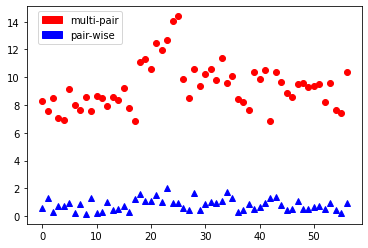

From 0 to 2 , mean transformation error: 338.221717008588 Pair-wise error : 155.6222843896576
Number of points = 59 std_multipair= 106.57207782680496 std_pair= 87.25057009951604


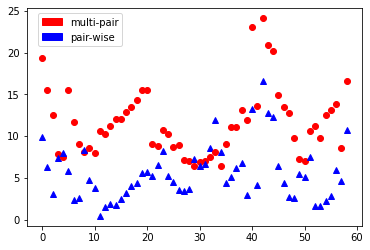

From 0 to 3 , mean transformation error: 303.5668552844152 Pair-wise error : 144.54737682917792
Number of points = 52 std_multipair= 71.27602283256073 std_pair= 97.6908753767044


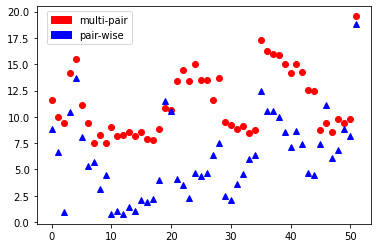

In [74]:
rmse_vec=np.zeros([N-1,objectPoints[0].shape[0]],dtype=np.float64)
rmse_vec_pair=np.zeros([N-1,objectPoints[0].shape[0]],dtype=np.float64)
write_file1 =os.path.join("/home/daniela/workspace/ball_detection/notebooks", "rmse1_sep1.csv")
write_file2 =os.path.join("/home/daniela/workspace/ball_detection/notebooks", "rmse2_sep1.csv")
write_file3 =os.path.join("/home/daniela/workspace/ball_detection/notebooks", "rmse3_sep1.csv")



f1 = open(write_file1, "w")
f2 = open(write_file2, "w")
f3 = open(write_file3, "w")
print(errors)
for i in range(0,len(ht)):
    m = objectPoints[0][chauvenet2(rmse_vec_pairwise1[i,:])].shape[1]
    src = np.ones((m+1,objectPoints[0][chauvenet2(rmse_vec_pairwise1[i,:])].shape[0]))
    src[:m,:] = np.copy(objectPoints[0][chauvenet2(rmse_vec_pairwise1[i,:])].T)
    dst_ht=np.dot(ht[i], src)

    rmse=mean_squared_error(dst_ht[:m,:].T,objectPoints[i+1][chauvenet2(rmse_vec_pairwise1[i,:])],squared=False)
    np.set_printoptions(precision=2,suppress=True)
    print("From 0 to", i+1, ", mean transformation error:",rmse, "Pair-wise error :", errors[0][i+1])
#     print(dst_ht[:m,0].T,objectPoints[i+1][0] )
    for n in range(0,objectPoints[0][chauvenet2(rmse_vec_pairwise1[i,:])].shape[0]):
        points_i=objectPoints[i+1][chauvenet2(rmse_vec_pairwise1[i,:])]
#         print(points_i.shape)
        rmse1=mean_squared_error(dst_ht[:m,n].T,points_i[n],squared=False)
        rmse2=mean_squared_error(points[0][i+1][n],points_i[n],squared=False)
        
        D1=np.linalg.norm(dst_ht[:3,n])
        D2=np.linalg.norm(points[0][i+1][n])
        
        rmse1_p=rmse1/D1*100
        rmse2_p=rmse2/D2*100
        
        rmse_vec[i,n]=rmse1
        rmse_vec_pair[i,n]=rmse2
        
#         plt.plot(121,n,rmse1,'ro',n,rmse2,'b^')
        
        plt.plot(n,rmse1_p,'ro',n,rmse2_p,'b^')
        if i==0:
            f1.write("%f %f %f\n"%(n, rmse1_p,rmse2_p))
        if i==1:
            f2.write("%f %f %f\n"%(n, rmse1_p,rmse2_p))
        if i==2:
            f3.write("%f %f %f\n"%(n, rmse1_p,rmse2_p))
#     rmse1_vec[i,:]=rmse_vec[rmse_vec[i,:]!=0]
#         rmse2=mean_squared_error(dst_ht[:m,:].T,objectPoints[i+1],squared=False)

    std_multi=np.std(rmse_vec[i,:][rmse_vec[i,:]!=0], dtype=np.float64)
    std_pair=np.std(rmse_vec_pair[i,:][rmse_vec[i,:]!=0], dtype=np.float64)
    print("Number of points =",objectPoints[0][chauvenet2(rmse_vec_pairwise1[i,:])].shape[0], "std_multipair=",std_multi, "std_pair=",std_pair )
    red_patch = mpatches.Patch(color='red', label='multi-pair')
    blue_patch = mpatches.Patch(color='blue', label='pair-wise')
    plt.legend(bbox_to_anchor=(0.3, 1),handles=[red_patch,blue_patch])
    plt.show()
    


# print(rmse_vec)
f1.close()
f2.close()
f3.close()
# print(rmse_vec.shape)
# for i in range(0,len(ht)):
#     m = objectPoints[0].shape[1]
#     chavenet=chauvenet2(rmse_vec[i,:])
# #     print(chavenet)
#     objectPoints_i=np.zeros([3,rmse_vec[i,chavenet].shape[0]])
#     objectPoints_i=np.copy(objectPoints[i+1][chauvenet2(rmse_vec[i,:])])
# #     print(objectPoints_i)
#     src = np.ones((m+1,objectPoints_i.shape[0]))
#     src[:m,:] = np.copy(objectPoints[0][chauvenet(rmse_vec[i,:])].T)
#     dst_ht=np.dot(ht[i], src)
    

#     rmse=mean_squared_error(dst_ht[:m,:].T,objectPoints_i,squared=False)
#     print("From 0 to", i+1, ", mean transformation error:",rmse, "Pair-wise error :", errors[0][i+1])
# #     print(dst_ht[:m,0].T,objectPoints[i+1][0] )
#     for n in range(0,objectPoints_i.shape[0]):
#         rmse1=mean_squared_error(dst_ht[:m,n].T,objectPoints_i[n],squared=False)
#         rmse2=mean_squared_error(points[0][i+1][n],objectPoints_i[n],squared=False)
#         plt.plot(n,rmse1,'ro',n,rmse2,'b^')
# #         rmse2=mean_squared_error(dst_ht[:m,:].T,objectPoints[i+1],squared=False)
#     plt.show()
    

<h3>Plot transformed cloud and 2D projection in each axis plane</h3>

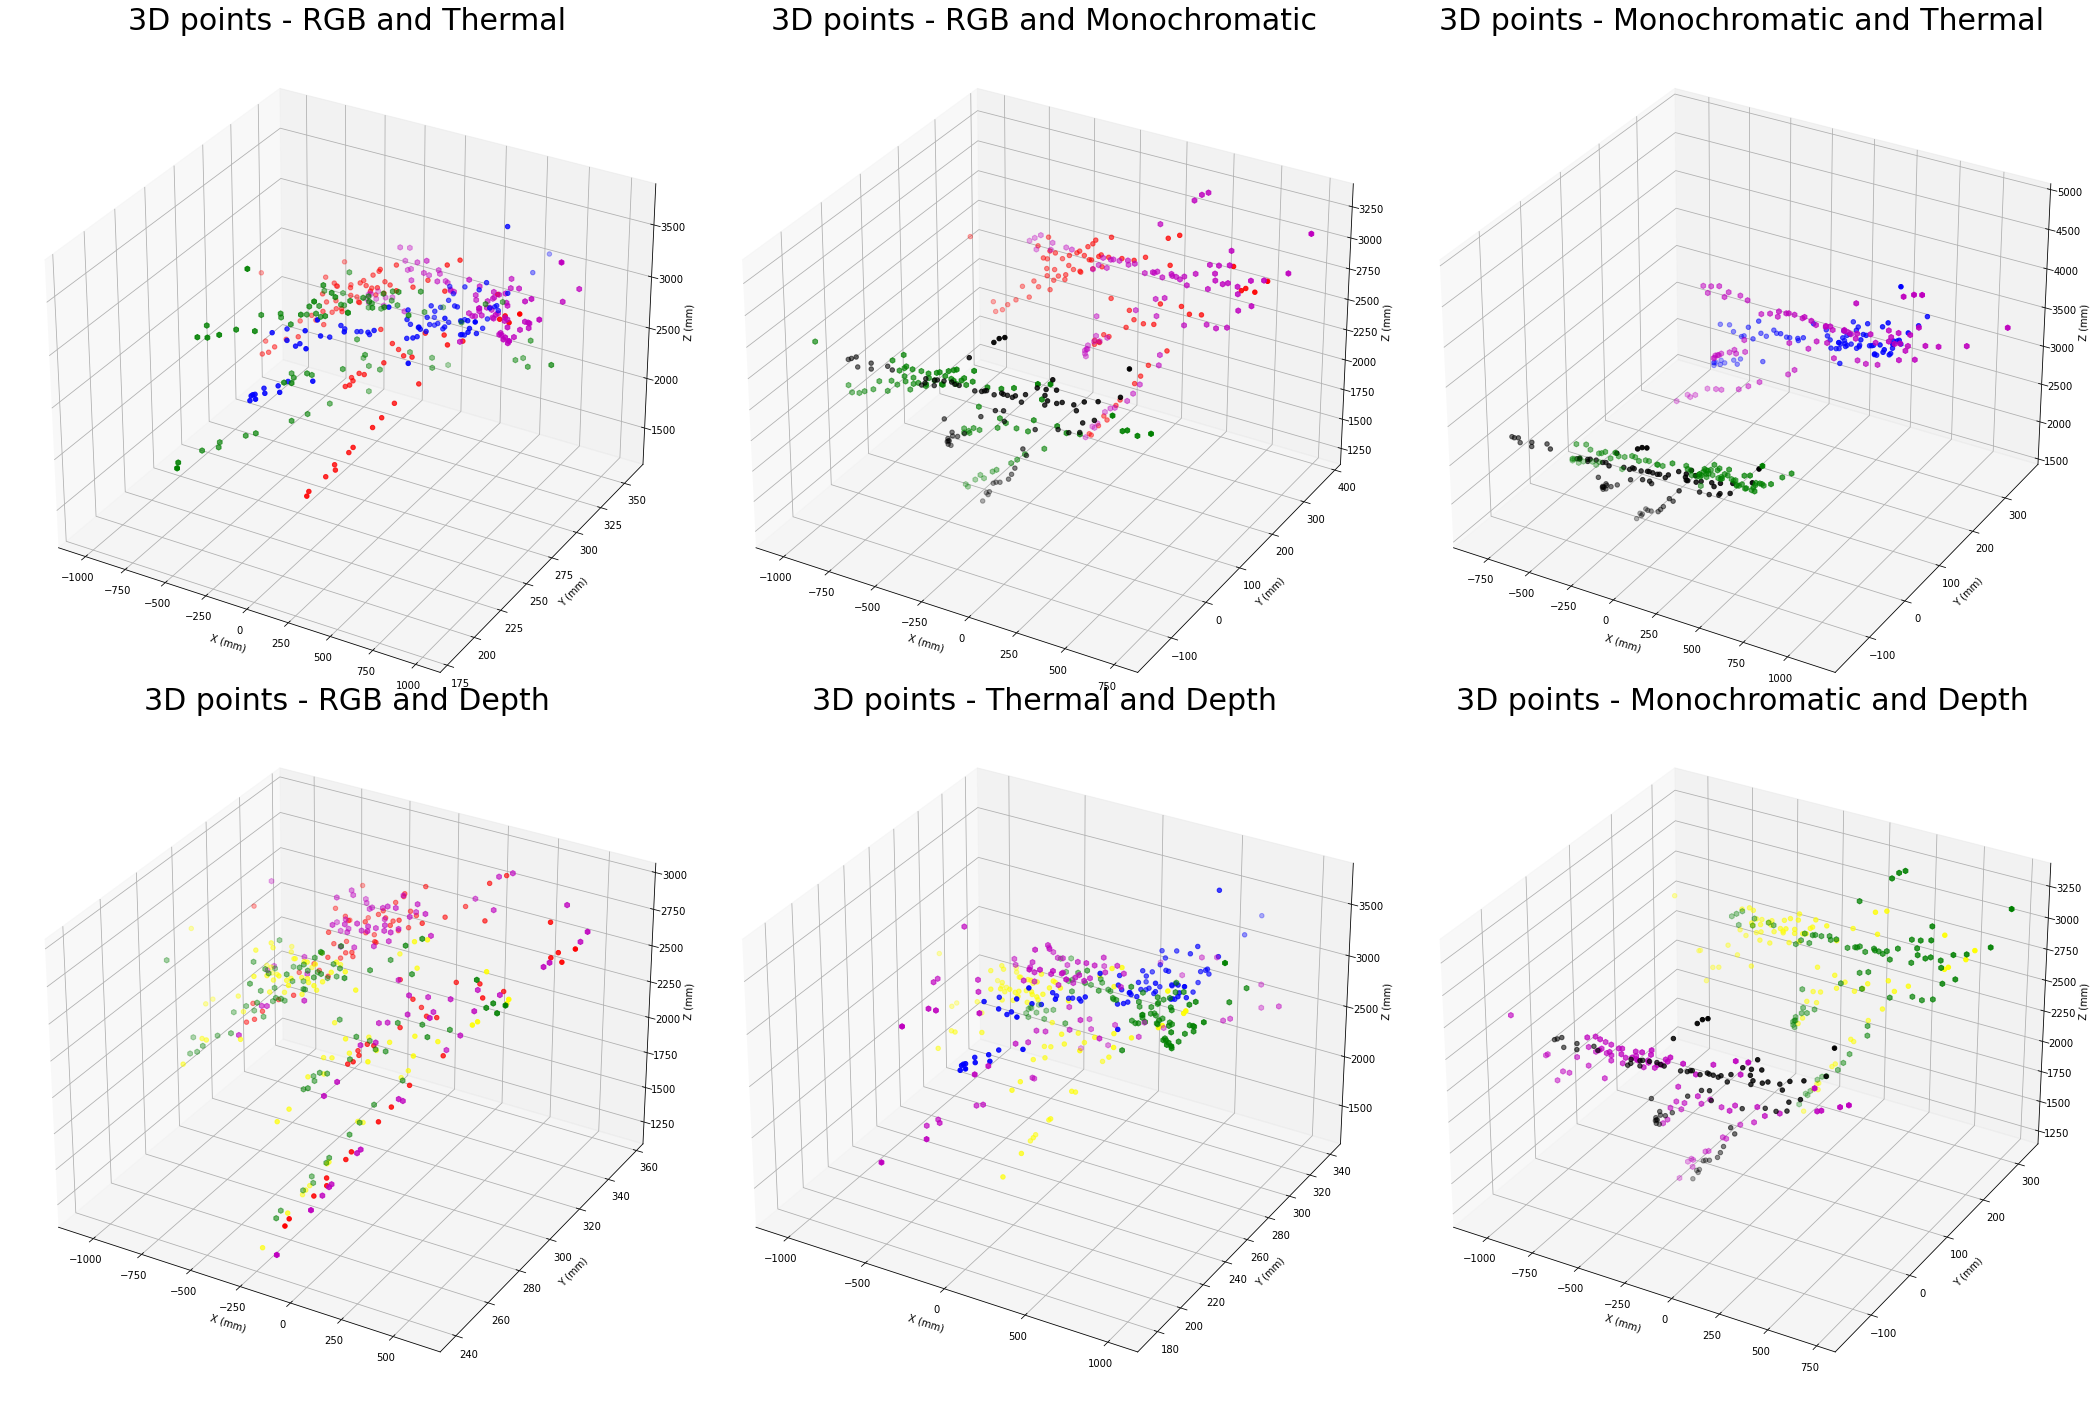

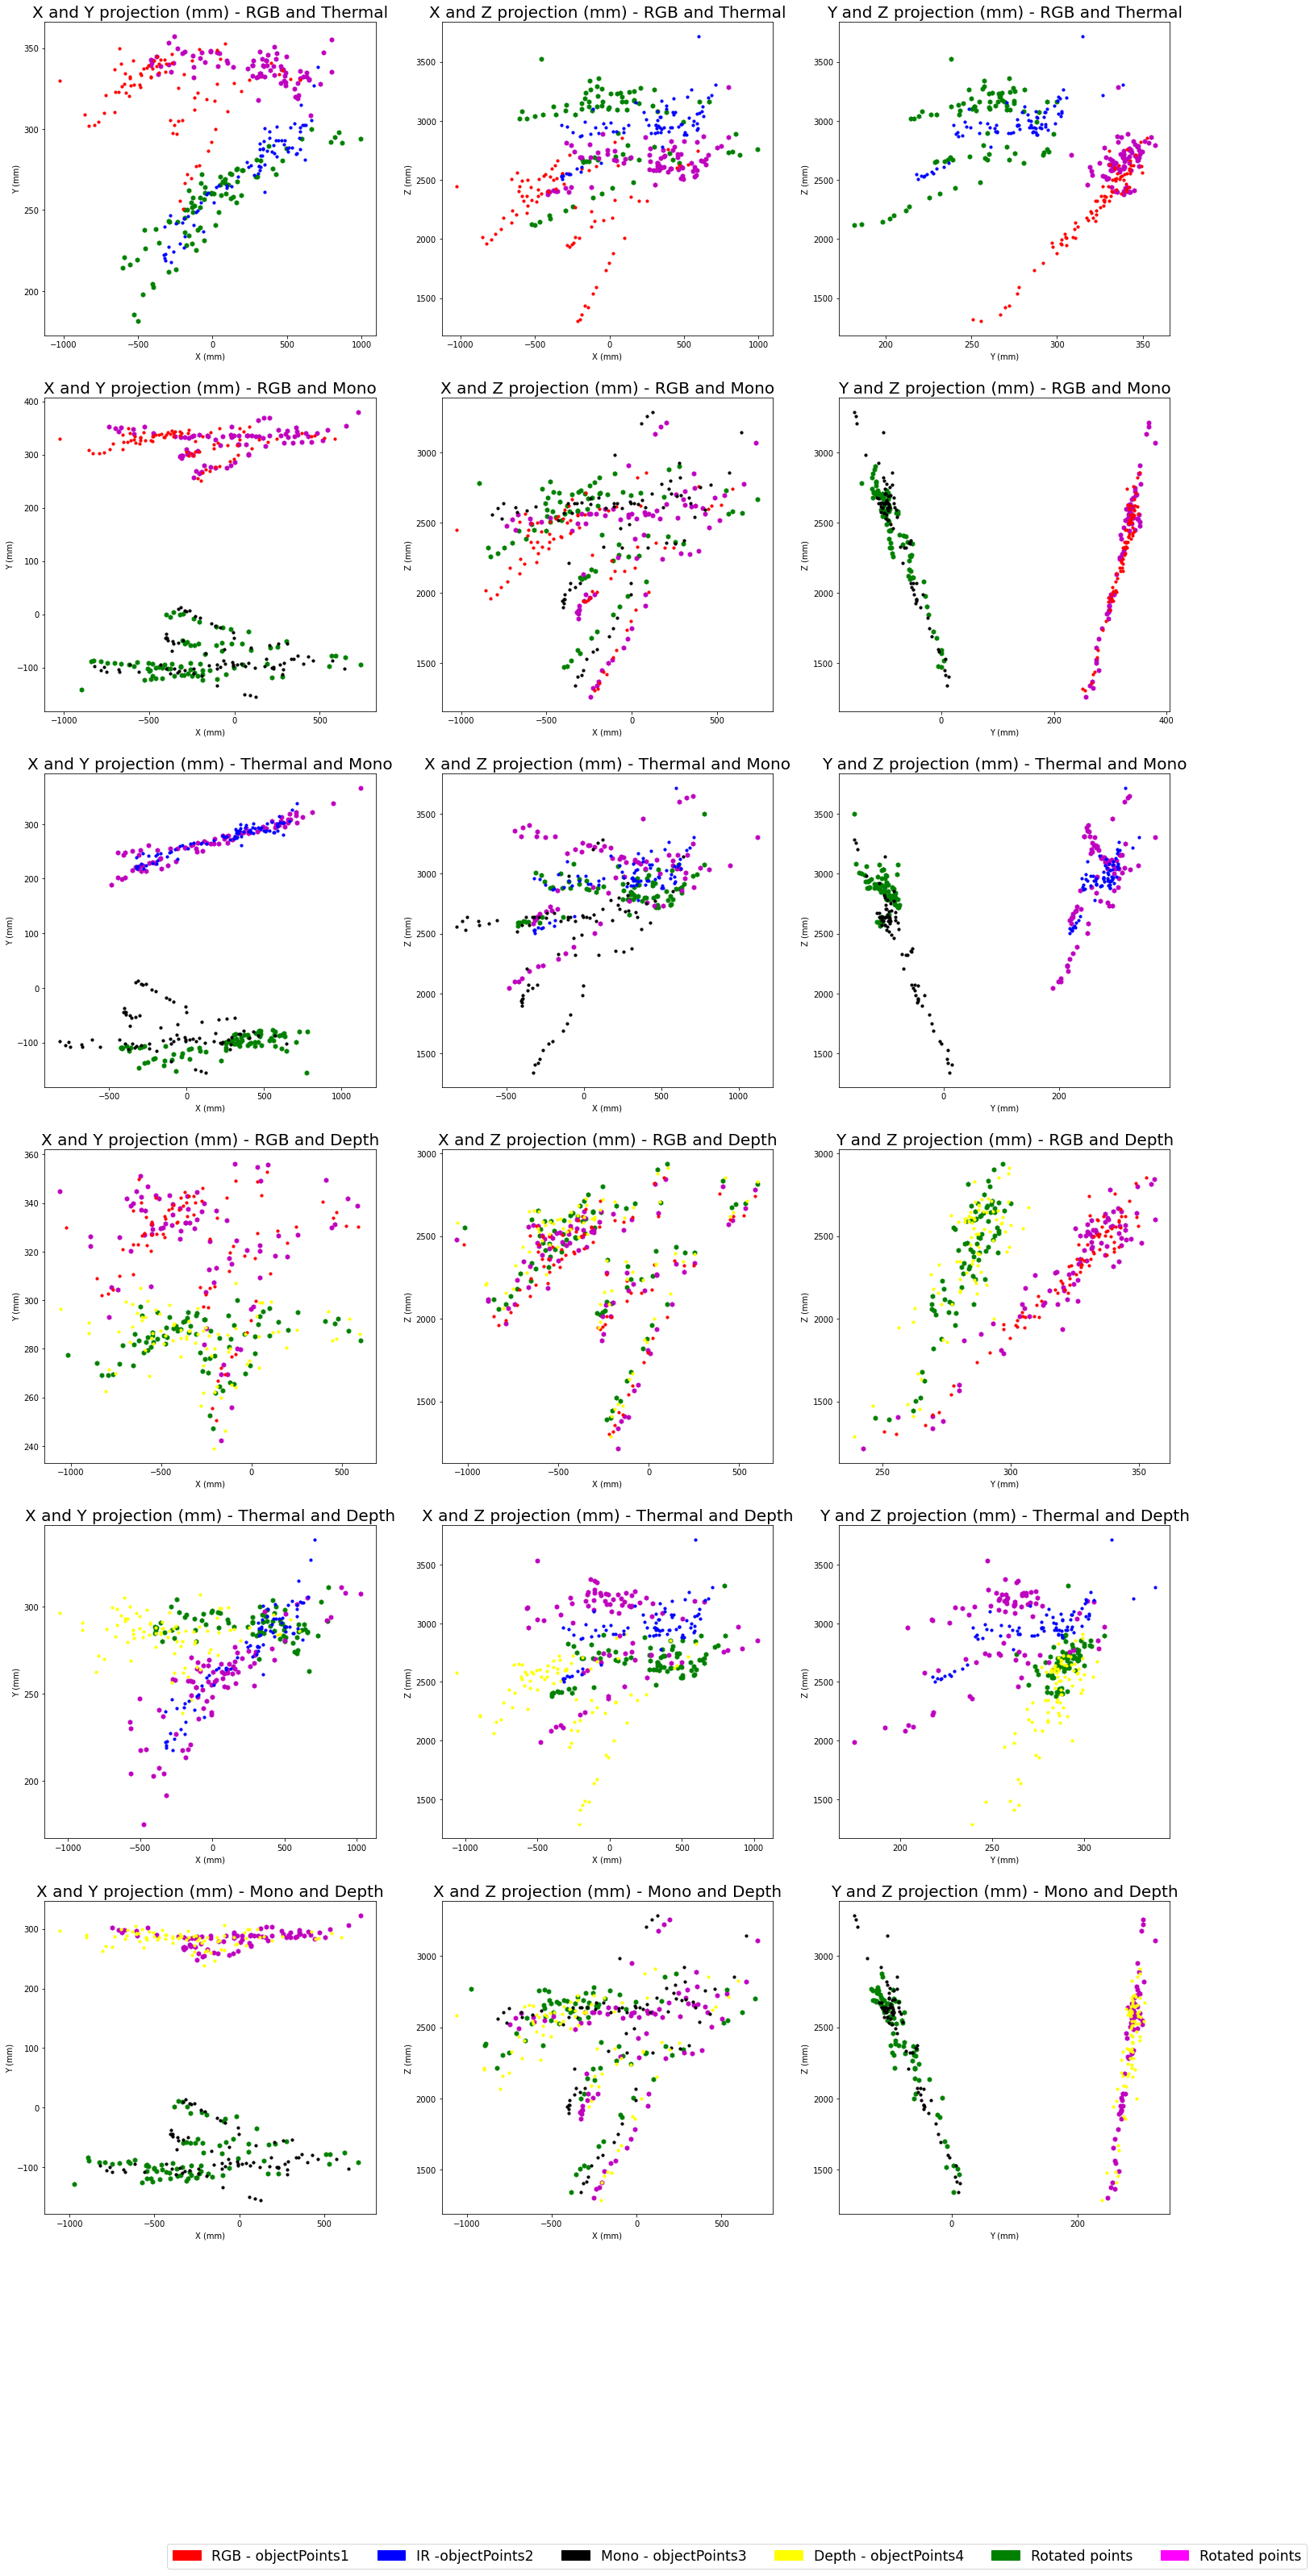

In [21]:
fig2 = plt.figure(figsize=(25*1.5,25))
ax2 = fig2.add_subplot(2,3,1, projection='3d')
fig2.subplots_adjust(wspace=0, hspace=0)

red_patch = mpatches.Patch(color='red', label='RGB - objectPoints1')
blue_patch = mpatches.Patch(color='blue', label='IR -objectPoints2')
black_patch = mpatches.Patch(color='black', label='Mono - objectPoints3')
green_patch = mpatches.Patch(color='green', label='Rotated points')
magenta_patch = mpatches.Patch(color='magenta', label='Rotated points')
yellow_patch = mpatches.Patch(color='yellow', label='Depth - objectPoints4')
# plt.legend(handles=[red_patch,blue_patch,black_patch,yellow_patch,green_patch,magenta_patch])

ax2.set_xlabel('X (mm)')
ax2.set_ylabel('Y (mm)')
ax2.set_zlabel('Z (mm)')
ax2.set_title("3D points - RGB and Thermal", fontsize=30)

ax2.scatter(transformed_points_12[:,0],transformed_points_12[:,1],transformed_points_12[:,2], c='g',marker="h",s=30)
ax2.scatter(transformed_points_21[:,0],transformed_points_21[:,1],transformed_points_21[:,2], c='m',marker="h",s=30)
ax2.scatter(objectPoints1[:,0],objectPoints1[:,1],objectPoints1[:,2], c='r') #rgb
ax2.scatter(objectPoints2[:,0],objectPoints2[:,1],objectPoints2[:,2], c='b') #termica
# ax2.scatter(objectPoints3[:,0],objectPoints3[:,1],objectPoints3[:,2], c='k') #mono
# ax2.scatter(objectPoints4[:,0],objectPoints4[:,1],objectPoints4[:,2], c='yellow') #mono

ax2 = fig2.add_subplot(2,3,2, projection='3d')
ax2.set_title("3D points - RGB and Monochromatic", fontsize=30)

ax2.set_xlabel('X (mm)')
ax2.set_ylabel('Y (mm)')
ax2.set_zlabel('Z (mm)')
ax2.scatter(transformed_points_13[:,0],transformed_points_13[:,1],transformed_points_13[:,2], c='g',marker="h",s=30)
ax2.scatter(transformed_points_31[:,0],transformed_points_31[:,1],transformed_points_31[:,2], c='m',marker="h",s=30)
ax2.scatter(objectPoints1[:,0],objectPoints1[:,1],objectPoints1[:,2], c='r') #rgb
# ax2.scatter(objectPoints2[:,0],objectPoints2[:,1],objectPoints2[:,2], c='b') #termica
ax2.scatter(objectPoints3[:,0],objectPoints3[:,1],objectPoints3[:,2], c='k') #mono
# ax2.scatter(objectPoints4[:,0],objectPoints4[:,1],objectPoints4[:,2], c='yellow') #mono


ax2 = fig2.add_subplot(2,3,3, projection='3d')
ax2.set_title("3D points - Monochromatic and Thermal", fontsize=30)

ax2.set_xlabel('X (mm)')
ax2.set_ylabel('Y (mm)')
ax2.set_zlabel('Z (mm)')
ax2.scatter(transformed_points_23[:,0],transformed_points_23[:,1],transformed_points_23[:,2], c='g',marker="h",s=30)
ax2.scatter(transformed_points_32[:,0],transformed_points_32[:,1],transformed_points_32[:,2], c='m',marker="h",s=30)
# ax2.scatter(objectPoints1[:,0],objectPoints1[:,1],objectPoints1[:,2], c='r') #rgb
ax2.scatter(objectPoints2[:,0],objectPoints2[:,1],objectPoints2[:,2], c='b') #termica
ax2.scatter(objectPoints3[:,0],objectPoints3[:,1],objectPoints3[:,2], c='k') #mono
# ax2.scatter(objectPoints4[:,0],objectPoints4[:,1],objectPoints4[:,2], c='yellow') #mono
ax2.set_zlim(1500,5000)



ax2 = fig2.add_subplot(2,3,4, projection='3d')
ax2.set_title("3D points - RGB and Depth", fontsize=30)

ax2.set_xlabel('X (mm)')
ax2.set_ylabel('Y (mm)')
ax2.set_zlabel('Z (mm)')
ax2.scatter(transformed_points_14[:,0],transformed_points_14[:,1],transformed_points_14[:,2], c='g',marker="h",s=30)
ax2.scatter(transformed_points_41[:,0],transformed_points_41[:,1],transformed_points_41[:,2], c='m',marker="h",s=30)
ax2.scatter(objectPoints1[:,0],objectPoints1[:,1],objectPoints1[:,2], c='r') #rgb
# ax2.scatter(objectPoints2[:,0],objectPoints2[:,1],objectPoints2[:,2], c='b') #termica
# ax2.scatter(objectPoints3[:,0],objectPoints3[:,1],objectPoints3[:,2], c='k') #mono
ax2.scatter(objectPoints4[:,0],objectPoints4[:,1],objectPoints4[:,2], c='yellow') #mono

ax2 = fig2.add_subplot(2,3,5, projection='3d')
ax2.set_title("3D points - Thermal and Depth", fontsize=30)

ax2.set_xlabel('X (mm)')
ax2.set_ylabel('Y (mm)')
ax2.set_zlabel('Z (mm)')
ax2.scatter(transformed_points_24[:,0],transformed_points_24[:,1],transformed_points_24[:,2], c='g',marker="h",s=30)
ax2.scatter(transformed_points_42[:,0],transformed_points_42[:,1],transformed_points_42[:,2], c='m',marker="h",s=30)
# ax2.scatter(objectPoints1[:,0],objectPoints1[:,1],objectPoints1[:,2], c='r') #rgb
ax2.scatter(objectPoints2[:,0],objectPoints2[:,1],objectPoints2[:,2], c='b') #termica
# ax2.scatter(objectPoints3[:,0],objectPoints3[:,1],objectPoints3[:,2], c='k') #mono
ax2.scatter(objectPoints4[:,0],objectPoints4[:,1],objectPoints4[:,2], c='yellow') #mono

ax2 = fig2.add_subplot(2,3,6, projection='3d')
ax2.set_title("3D points - Monochromatic and Depth", fontsize=30)
ax2.set_xlabel('X (mm)')
ax2.set_ylabel('Y (mm)')
ax2.set_zlabel('Z (mm)')
ax2.scatter(transformed_points_34[:,0],transformed_points_34[:,1],transformed_points_34[:,2], c='g',marker="h",s=30)
ax2.scatter(transformed_points_43[:,0],transformed_points_43[:,1],transformed_points_43[:,2], c='m',marker="h",s=30)
# ax2.scatter(objectPoints1[:,0],objectPoints1[:,1],objectPoints1[:,2], c='r') #rgb
# ax2.scatter(objectPoints2[:,0],objectPoints2[:,1],objectPoints2[:,2], c='b') #termica
ax2.scatter(objectPoints3[:,0],objectPoints3[:,1],objectPoints3[:,2], c='k') #mono
ax2.scatter(objectPoints4[:,0],objectPoints4[:,1],objectPoints4[:,2], c='yellow') #mono
# ax2.set_zlim(1500,5000)



fig_final, axs_f = plt.subplots(6,3,figsize=(25,50))
fig_final.legend(handles=[red_patch,blue_patch,black_patch,yellow_patch,green_patch,magenta_patch],loc=4,ncol=6,fontsize='xx-large')

axs_f[0,0].scatter(transformed_points_12[:,0],transformed_points_12[:,1], c='g',marker="h",s=30)
axs_f[0,0].scatter(transformed_points_21[:,0],transformed_points_21[:,1], c='m',marker="h",s=30)
axs_f[0,0].scatter(objectPoints1[:,0],objectPoints1[:,1], c='r',s=10)
axs_f[0,0].scatter(objectPoints2[:,0],objectPoints2[:,1], c='b',s=10)  

axs_f[0,0].set_xlabel('X (mm)')
axs_f[0,0].set_ylabel('Y (mm)')
axs_f[0,0].set_title('X and Y projection (mm) - RGB and Thermal', fontsize=20)

axs_f[0,1].scatter(transformed_points_12[:,0],transformed_points_12[:,2], c='g',marker="h",s=30)
axs_f[0,1].scatter(transformed_points_21[:,0],transformed_points_21[:,2], c='m',marker="h",s=30)
axs_f[0,1].scatter(objectPoints1[:,0],objectPoints1[:,2], c='r',s=10)
axs_f[0,1].scatter(objectPoints2[:,0],objectPoints2[:,2], c='b',s=10)
axs_f[0,1].set_xlabel('X (mm)')
axs_f[0,1].set_ylabel('Z (mm)')
# axs_f[0,1].set_ylim(1500,5000)
axs_f[0,1].set_title('X and Z projection (mm) - RGB and Thermal', fontsize=20)

axs_f[0,2].scatter(transformed_points_12[:,1],transformed_points_12[:,2], c='g',marker="h",s=30)
axs_f[0,2].scatter(transformed_points_21[:,1],transformed_points_21[:,2], c='m',marker="h",s=30)
axs_f[0,2].scatter(objectPoints1[:,1],objectPoints1[:,2], c='r',s=10)
axs_f[0,2].scatter(objectPoints2[:,1],objectPoints2[:,2], c='b',s=10)
axs_f[0,2].set_xlabel('Y (mm)')
axs_f[0,2].set_ylabel('Z (mm)')
# axs_f[0,2].set_ylim(1500,5000)
axs_f[0,2].set_title('Y and Z projection (mm) - RGB and Thermal', fontsize=20)

axs_f[1,0].scatter(transformed_points_13[:,0],transformed_points_13[:,1], c='g',marker="h",s=30)
axs_f[1,0].scatter(transformed_points_31[:,0],transformed_points_31[:,1], c='m',marker="h",s=30)
axs_f[1,0].scatter(objectPoints1[:,0],objectPoints1[:,1], c='r',s=10)
axs_f[1,0].scatter(objectPoints3[:,0],objectPoints3[:,1], c='k',s=10) #termica 
axs_f[1,0].set_xlabel('X (mm)')
axs_f[1,0].set_ylabel('Y (mm)')
axs_f[1,0].set_title('X and Y projection (mm) - RGB and Mono', fontsize=20)

axs_f[1,1].scatter(transformed_points_13[:,0],transformed_points_13[:,2], c='g',marker="h",s=30)
axs_f[1,1].scatter(transformed_points_31[:,0],transformed_points_31[:,2], c='m',marker="h",s=30)
axs_f[1,1].scatter(objectPoints1[:,0],objectPoints1[:,2], c='r',s=10)
axs_f[1,1].scatter(objectPoints3[:,0],objectPoints3[:,2], c='k',s=10)
axs_f[1,1].set_xlabel('X (mm)')
axs_f[1,1].set_ylabel('Z (mm)')
# axs_f[1,1].set_ylim(1500,5000)
axs_f[1,1].set_title('X and Z projection (mm) - RGB and Mono', fontsize=20)

axs_f[1,2].scatter(transformed_points_13[:,1],transformed_points_13[:,2], c='g',marker="h",s=30)
axs_f[1,2].scatter(transformed_points_31[:,1],transformed_points_31[:,2], c='m',marker="h",s=30)
axs_f[1,2].scatter(objectPoints1[:,1],objectPoints1[:,2], c='r',s=10)
axs_f[1,2].scatter(objectPoints3[:,1],objectPoints3[:,2], c='k',s=10)
axs_f[1,2].set_xlabel('Y (mm)')
axs_f[1,2].set_ylabel('Z (mm)')
# axs_f[1,2].set_ylim(1500,5000)
axs_f[1,2].set_title('Y and Z projection (mm) - RGB and Mono', fontsize=20)

axs_f[2,0].scatter(transformed_points_23[:,0],transformed_points_23[:,1], c='g',marker="h",s=30)
axs_f[2,0].scatter(transformed_points_32[:,0],transformed_points_32[:,1], c='m',marker="h",s=30)
axs_f[2,0].scatter(objectPoints2[:,0],objectPoints2[:,1], c='b',s=10) #termica 
axs_f[2,0].scatter(objectPoints3[:,0],objectPoints3[:,1], c='k',s=10) #termica 
axs_f[2,0].set_xlabel('X (mm)')
axs_f[2,0].set_ylabel('Y (mm)')
axs_f[2,0].set_title('X and Y projection (mm) - Thermal and Mono', fontsize=20)

axs_f[2,1].scatter(transformed_points_23[:,0],transformed_points_23[:,2], c='g',marker="h",s=30)
axs_f[2,1].scatter(transformed_points_32[:,0],transformed_points_32[:,2], c='m',marker="h",s=30)
axs_f[2,1].scatter(objectPoints2[:,0],objectPoints2[:,2], c='b',s=10)
axs_f[2,1].scatter(objectPoints3[:,0],objectPoints3[:,2], c='k',s=10)
axs_f[2,1].set_xlabel('X (mm)')
axs_f[2,1].set_ylabel('Z (mm)')
# axs_f[2,1].set_ylim(1500,5000)
axs_f[2,1].set_title('X and Z projection (mm) - Thermal and Mono', fontsize=20)

axs_f[2,2].scatter(transformed_points_23[:,1],transformed_points_23[:,2], c='g',marker="h",s=30)
axs_f[2,2].scatter(transformed_points_32[:,1],transformed_points_32[:,2], c='m',marker="h",s=30)
axs_f[2,2].scatter(objectPoints2[:,1],objectPoints2[:,2], c='b',s=10)
axs_f[2,2].scatter(objectPoints3[:,1],objectPoints3[:,2], c='k',s=10)
axs_f[2,2].set_xlabel('Y (mm)')
axs_f[2,2].set_ylabel('Z (mm)')
# axs_f[2,2].set_ylim(1500,5000)
axs_f[2,2].set_title('Y and Z projection (mm) - Thermal and Mono', fontsize=20)


axs_f[3,0].scatter(transformed_points_14[:,0],transformed_points_14[:,1], c='g',marker="h",s=30)
axs_f[3,0].scatter(transformed_points_41[:,0],transformed_points_41[:,1], c='m',marker="h",s=30)
axs_f[3,0].scatter(objectPoints1[:,0],objectPoints1[:,1], c='r',s=10)
axs_f[3,0].scatter(objectPoints4[:,0],objectPoints4[:,1], c='yellow',s=10)  
axs_f[3,0].set_xlabel('X (mm)')
axs_f[3,0].set_ylabel('Y (mm)')
axs_f[3,0].set_title('X and Y projection (mm) - RGB and Depth', fontsize=20)

axs_f[3,1].scatter(transformed_points_14[:,0],transformed_points_14[:,2], c='g',marker="h",s=30)
axs_f[3,1].scatter(transformed_points_41[:,0],transformed_points_41[:,2], c='m',marker="h",s=30)
axs_f[3,1].scatter(objectPoints1[:,0],objectPoints1[:,2], c='r',s=10)
axs_f[3,1].scatter(objectPoints4[:,0],objectPoints4[:,2], c='yellow',s=10)
axs_f[3,1].set_xlabel('X (mm)')
axs_f[3,1].set_ylabel('Z (mm)')
# axs_f[3,1].set_ylim(1500,5000)
axs_f[3,1].set_title('X and Z projection (mm) - RGB and Depth', fontsize=20)

axs_f[3,2].scatter(transformed_points_14[:,1],transformed_points_14[:,2], c='g',marker="h",s=30)
axs_f[3,2].scatter(transformed_points_41[:,1],transformed_points_41[:,2], c='m',marker="h",s=30)
axs_f[3,2].scatter(objectPoints1[:,1],objectPoints1[:,2], c='r',s=10)
axs_f[3,2].scatter(objectPoints4[:,1],objectPoints4[:,2], c='yellow',s=10)
axs_f[3,2].set_xlabel('Y (mm)')
axs_f[3,2].set_ylabel('Z (mm)')
# axs_f[3,2].set_ylim(1500,5000)
axs_f[3,2].set_title('Y and Z projection (mm) - RGB and Depth', fontsize=20)

axs_f[4,0].scatter(transformed_points_24[:,0],transformed_points_24[:,1], c='g',marker="h",s=30)
axs_f[4,0].scatter(transformed_points_42[:,0],transformed_points_42[:,1], c='m',marker="h",s=30)
axs_f[4,0].scatter(objectPoints4[:,0],objectPoints4[:,1], c='yellow',s=10)
axs_f[4,0].scatter(objectPoints2[:,0],objectPoints2[:,1], c='b',s=10) #termica 
axs_f[4,0].set_xlabel('X (mm)')
axs_f[4,0].set_ylabel('Y (mm)')
axs_f[4,0].set_title('X and Y projection (mm) - Thermal and Depth', fontsize=20)

axs_f[4,1].scatter(transformed_points_24[:,0],transformed_points_24[:,2], c='g',marker="h",s=30)
axs_f[4,1].scatter(transformed_points_42[:,0],transformed_points_42[:,2], c='m',marker="h",s=30)
axs_f[4,1].scatter(objectPoints4[:,0],objectPoints4[:,2], c='yellow',s=10)
axs_f[4,1].scatter(objectPoints2[:,0],objectPoints2[:,2], c='b',s=10)
axs_f[4,1].set_xlabel('X (mm)')
axs_f[4,1].set_ylabel('Z (mm)')
# axs_f[4,1].set_ylim(1500,5000)
axs_f[4,1].set_title('X and Z projection (mm) - Thermal and Depth', fontsize=20)

axs_f[4,2].scatter(transformed_points_24[:,1],transformed_points_24[:,2], c='g',marker="h",s=30)
axs_f[4,2].scatter(transformed_points_42[:,1],transformed_points_42[:,2], c='m',marker="h",s=30)
axs_f[4,2].scatter(objectPoints4[:,1],objectPoints4[:,2], c='yellow',s=10)
axs_f[4,2].scatter(objectPoints2[:,1],objectPoints2[:,2], c='b',s=10)
axs_f[4,2].set_xlabel('Y (mm)')
axs_f[4,2].set_ylabel('Z (mm)')
# axs_f[4,2].set_ylim(1500,5000)
axs_f[4,2].set_title('Y and Z projection (mm) - Thermal and Depth', fontsize=20)

axs_f[5,0].scatter(transformed_points_43[:,0],transformed_points_43[:,1], c='g',marker="h",s=30)
axs_f[5,0].scatter(transformed_points_34[:,0],transformed_points_34[:,1], c='m',marker="h",s=30)
axs_f[5,0].scatter(objectPoints3[:,0],objectPoints3[:,1], c='k',s=10)
axs_f[5,0].scatter(objectPoints4[:,0],objectPoints4[:,1], c='yellow',s=10) #termica 
axs_f[5,0].set_xlabel('X (mm)')
axs_f[5,0].set_ylabel('Y (mm)')
axs_f[5,0].set_title('X and Y projection (mm) - Mono and Depth', fontsize=20)

axs_f[5,1].scatter(transformed_points_43[:,0],transformed_points_43[:,2], c='g',marker="h",s=30)
axs_f[5,1].scatter(transformed_points_34[:,0],transformed_points_34[:,2], c='m',marker="h",s=30)
axs_f[5,1].scatter(objectPoints3[:,0],objectPoints3[:,2], c='k',s=10)
axs_f[5,1].scatter(objectPoints4[:,0],objectPoints4[:,2], c='yellow',s=10)
axs_f[5,1].set_xlabel('X (mm)')
axs_f[5,1].set_ylabel('Z (mm)')
# axs_f[5,1].set_ylim(1500,5000)
axs_f[5,1].set_title('X and Z projection (mm) - Mono and Depth', fontsize=20)

axs_f[5,2].scatter(transformed_points_43[:,1],transformed_points_43[:,2], c='g',marker="h",s=30)
axs_f[5,2].scatter(transformed_points_34[:,1],transformed_points_34[:,2], c='m',marker="h",s=30)
axs_f[5,2].scatter(objectPoints3[:,1],objectPoints3[:,2], c='k',s=10)
axs_f[5,2].scatter(objectPoints4[:,1],objectPoints4[:,2], c='yellow',s=10)
axs_f[5,2].set_xlabel('Y (mm)')
axs_f[5,2].set_ylabel('Z (mm)')
# axs_f[5,2].set_ylim(1500,5000)
axs_f[5,2].set_title('Y and Z projection (mm) - Mono and Depth', fontsize=20)


plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)
plt.show()
fig2.savefig('gymball.png')
fig_final.savefig('gymball2.png')

<h1>Calculate transformations (from Thermal to RGB) </h1> 

Text(0.5, 1.0, 'Y and Z projection (mm) - RGB and Mono')

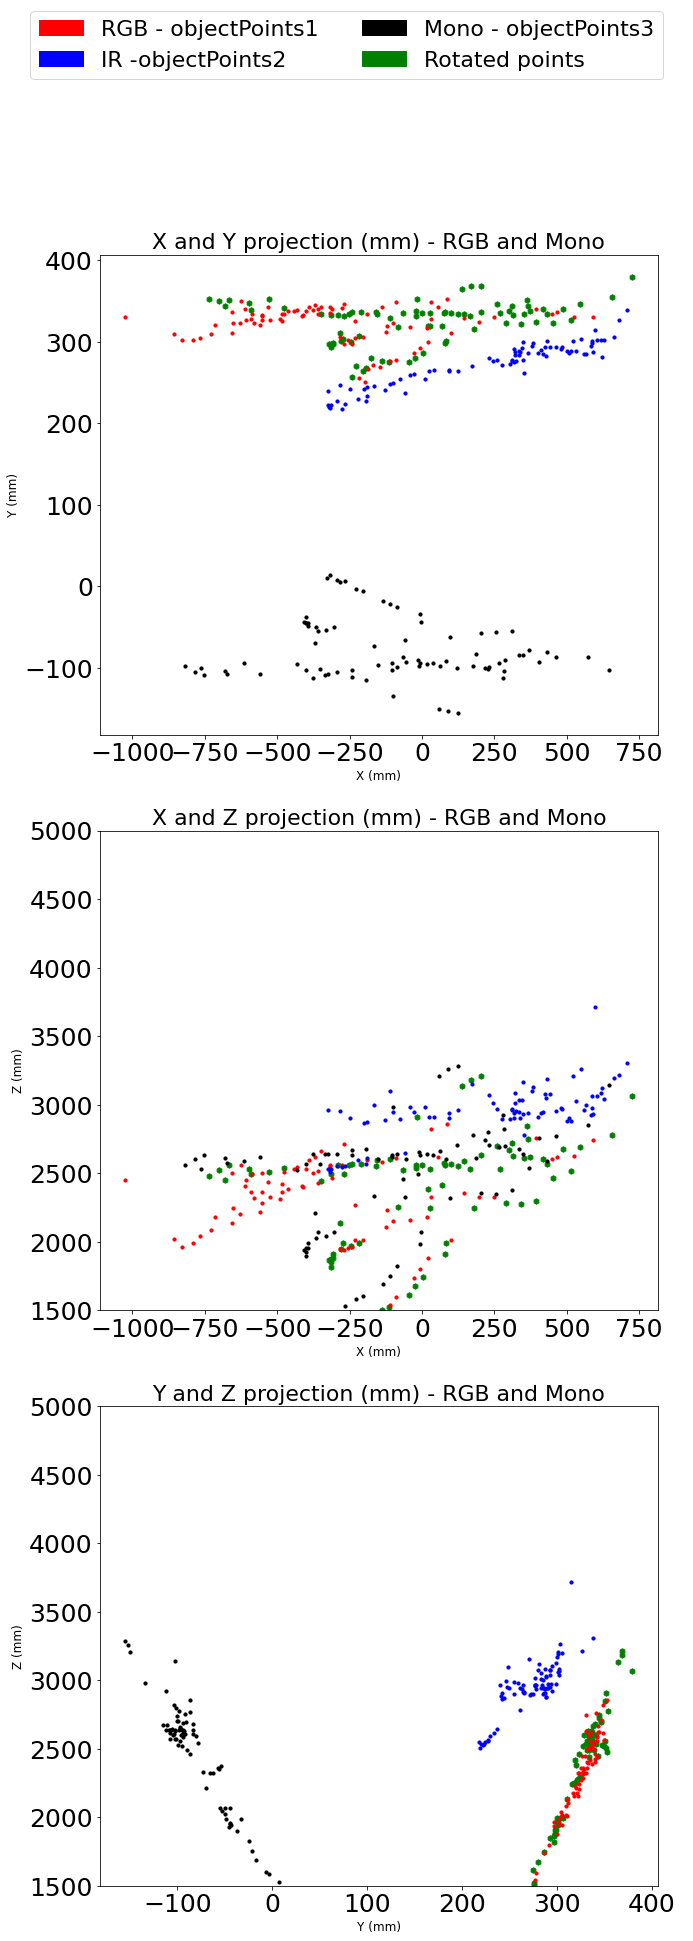

In [22]:
fig_final, axs_f = plt.subplots(3,1,figsize=(10,30))
fig_final.legend(handles=[red_patch,blue_patch,black_patch,green_patch],loc=9,ncol=2,fontsize=22)

plt.rc('xtick', labelsize=22)    # fontsize of the tick labels
plt.rc('ytick', labelsize=22)    # fontsize of the tick labels

# axs_f[0].scatter(transformed_points_13[:,0],transformed_points_13[:,1], c='g',marker="h",s=30)
axs_f[0].scatter(transformed_points_31[:,0],transformed_points_31[:,1], c='g',marker="h",s=30)
axs_f[0].scatter(objectPoints1[:,0],objectPoints1[:,1], c='r',s=10)
axs_f[0].scatter(objectPoints2[:,0],objectPoints2[:,1], c='b',s=10) #termica 
axs_f[0].scatter(objectPoints3[:,0],objectPoints3[:,1], c='k',s=10) #termica 
axs_f[0].set_xlabel('X (mm)', fontsize=12)
axs_f[0].set_ylabel('Y (mm)', fontsize=12)
axs_f[0].set_title('X and Y projection (mm) - RGB and Mono',fontsize=22)

# axs_f[1].scatter(transformed_points_13[:,0],transformed_points_13[:,2], c='g',marker="h",s=30)
axs_f[1].scatter(transformed_points_31[:,0],transformed_points_31[:,2], c='g',marker="h",s=30)
axs_f[1].scatter(objectPoints1[:,0],objectPoints1[:,2], c='r',s=10)
axs_f[1].scatter(objectPoints2[:,0],objectPoints2[:,2], c='b',s=10)
axs_f[1].scatter(objectPoints3[:,0],objectPoints3[:,2], c='k',s=10)
axs_f[1].set_xlabel('X (mm)', fontsize=12)
axs_f[1].set_ylabel('Z (mm)', fontsize=12)
axs_f[1].set_ylim(1500,5000)
axs_f[1].set_title('X and Z projection (mm) - RGB and Mono',fontsize=22)

# axs_f[2].scatter(transformed_points_13[:,1],transformed_points_13[:,2], c='g',marker="h",s=30)
axs_f[2].scatter(transformed_points_31[:,1],transformed_points_31[:,2], c='g',marker="h",s=30)
axs_f[2].scatter(objectPoints1[:,1],objectPoints1[:,2], c='r',s=10)
axs_f[2].scatter(objectPoints2[:,1],objectPoints2[:,2], c='b',s=10)
axs_f[2].scatter(objectPoints3[:,1],objectPoints3[:,2], c='k',s=10)
axs_f[2].set_xlabel('Y (mm)', fontsize=12)
axs_f[2].set_ylabel('Z (mm)', fontsize=12)
axs_f[2].set_ylim(1500,5000)
axs_f[2].set_title('Y and Z projection (mm) - RGB and Mono',fontsize=22)

In [23]:
write_file =os.path.join("/home/daniela/workspace/ball_detection/notebooks", "4cams_new.csv")
f = open(write_file, "w")
for i in range(len(objectPoints1)):
    f.write("%f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f\n"%(objectPoints1[i,0],objectPoints1[i,1],objectPoints1[i,2],objectPoints2[i,0],objectPoints2[i,1],objectPoints2[i,2],objectPoints3[i,0],objectPoints3[i,1],objectPoints3[i,2],objectPoints4[i,0],objectPoints4[i,1],objectPoints4[i,2],transformed_points_12[i,0],transformed_points_12[i,1],transformed_points_12[i,2],transformed_points_21[i,0],transformed_points_21[i,1],transformed_points_21[i,2],transformed_points_13[i,0],transformed_points_13[i,1],transformed_points_13[i,2],transformed_points_31[i,0],transformed_points_31[i,1],transformed_points_31[i,2],transformed_points_14[i,0],transformed_points_14[i,1],transformed_points_14[i,2],transformed_points_41[i,0],transformed_points_41[i,1],transformed_points_41[i,2],transformed_points_23[i,0],transformed_points_23[i,1],transformed_points_23[i,2],transformed_points_32[i,0],transformed_points_32[i,1],transformed_points_32[i,2],transformed_points_24[i,0],transformed_points_24[i,1],transformed_points_24[i,2],transformed_points_42[i,0],transformed_points_42[i,1],transformed_points_42[i,2],transformed_points_34[i,0],transformed_points_34[i,1],transformed_points_34[i,2],transformed_points_43[i,0],transformed_points_43[i,1],transformed_points_43[i,2]))

f.close()
# 48
